In [20]:
import os
import numpy as np
import numpy.random as rand
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure as meas, feature as feat
import cv2 as cv
from tqdm import tnrange, tqdm_notebook as tqdm
import pandas as pd

In [21]:
plt.rcParams["axes.axisbelow"] = True
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams["figure.dpi"] = 100

In [22]:
banana = pd.read_csv('banana.csv')
orange = pd.read_csv('orange.csv')
green_apple = pd.read_csv('green_apple.csv')

In [37]:
ban_a, ban_b, ban_c = np.array(banana['eccentricity']), np.array(banana['r']), np.array(banana['g'])
ora_a, ora_b, ora_c = np.array(orange['eccentricity']), np.array(orange['r']), np.array(orange['g'])
app_a, app_b, app_c = np.array(green_apple['eccentricity']), np.array(green_apple['r']), np.array(green_apple['g'])

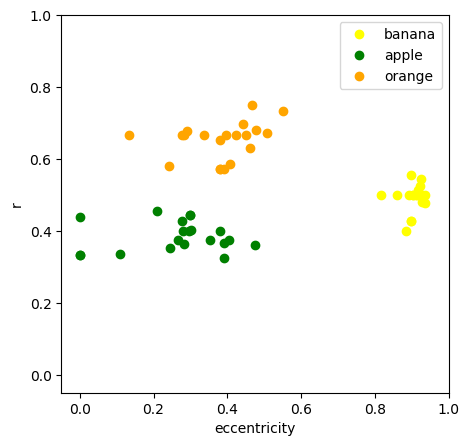

In [38]:
plt.plot(ban_a, ban_b, 'o', color='yellow')
plt.plot(app_a, app_b, 'go')
plt.plot(ora_a, ora_b, 'o', color='orange')
plt.legend(['banana', 'apple', 'orange'])
plt.xlabel('eccentricity')
plt.ylabel('r')
plt.xlim(-0.05,1)
plt.ylim(-0.05,1)
# plt.savefig('ab-space.png', dpi=300, bbox_inches='tight')
plt.show()

In [39]:
class MCPerceptron:
    def __init__(self,
                 input_shape, 
                 output_shape,
                 epochs,
                 activation='step',
                 lr=0.01,
                 eps=1e-6,
                 weight_initializer='random_uniform'):
        rand.seed(101)
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.epochs = epochs
        self.activation = activation
        self.lr = lr
        self.eps = eps
        self.weight_initializer = weight_initializer
        
        if self.weight_initializer == 'random_uniform':
            self.W = rand.random(self.input_shape[1])
        elif self.weight_initializer == 'random_normal':
            self.W = rand.normal((0, 1, (self.input_shape[1])))

        if self.activation == 'step':
            self.g = lambda a: 1 if a >= 0 else -1

    def train(self, x, y):
        self.graph_res = []
        for count in tnrange(self.epochs, desc='Epoch'):
            res = 0
            for i in range(self.input_shape[0]):
                a = x[i].T.dot(self.W)
                z = self.g(a)
                dW = self.lr * (y[i] - z) * x[i]
                self.W += dW
                res += (y[i] - z)**2
            res /= self.input_shape[0]
            self.graph_res.append(res)
            if res < self.eps:
                break
        self.last_epoch = count + 1
                 
    def predict(self, x):
        y = np.zeros(x.shape[0])
        for i in range(x.shape[0]):
            f = x[i].dot(self.W)
            y[i] = self.g(f)
        return y
                
    def get_weights(self):
        return self.W
    
    def get_biases(self):
        return self.x.T[0]

    def get_line_params(self):
        W = self.W
        A, B, C = W[1], W[2], -W[0]
        m = -A/B
        b = C/B
        return m, b
    
    def save_weights(self, filename):
        np.save(filename, self.W)
        
    def load_weights(self, filename):
        self.W = np.load(filename)

In [40]:
bounds = np.zeros(3, object)

/Users/kleo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: No contour levels were found within the data range.


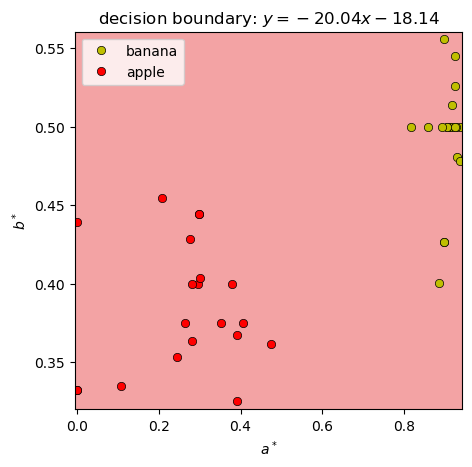

In [41]:
x = np.hstack(([ban_a, ban_b], [app_a, app_b])).T
x = np.column_stack((np.ones(x.shape[0]), x))
y = np.hstack((np.tile([1], 50), np.tile([-1], 50))).T
mcp = MCPerceptron(x.shape, y.shape, epochs=1000, lr=1e-1)
mcp.train(x, y)
W = mcp.get_weights()

xmin, xmax = np.min((ban_a, app_a))-5e-3, np.max((ban_a, app_a))+5e-3
ymin, ymax = np.min((ban_b, app_b))-5e-3, np.max((ban_b, app_b))+5e-3
db_x = np.linspace(xmin, xmax, 100)
db_y = np.linspace(ymin, ymax, 100)
xx, yy = np.meshgrid(db_x, db_y)
Z = mcp.predict(np.c_[np.ones_like(xx.ravel()), xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap='YlOrRd_r', alpha=0.4)
plt.contour(xx, yy, Z, colors='k', linewidths=0.5)
plt.plot(ban_a, ban_b, 'yo', mec='k', mew=0.5, label='banana')
plt.plot(app_a, app_b, 'ro', mec='k', mew=0.5, label='apple')

decision_boundary = mcp.get_line_params()
bounds[0] = decision_boundary
decision_title = 'decision boundary: $y = %.2fx + %.2f$' if decision_boundary[1] >= 0 \
                 else 'decision boundary: $y = %.2fx - %.2f$'
plt.title(decision_title %(decision_boundary[0], abs(decision_boundary[1])))
plt.legend()
plt.xlabel('$a^*$')
plt.ylabel('$b^*$')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
# plt.savefig('ban-app_decision.png', dpi=300, bbox_inches='tight')
plt.show()

/Users/kleo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: No contour levels were found within the data range.


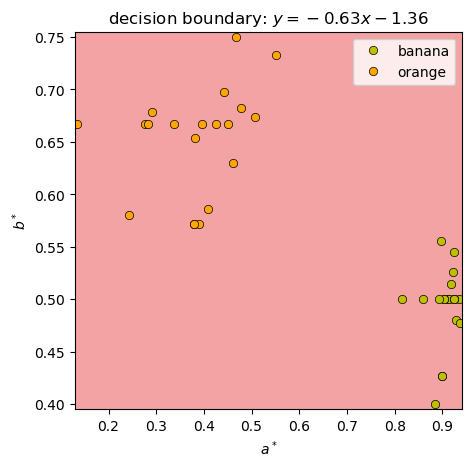

In [28]:
x = np.hstack(([ban_a, ban_b], [ora_a, ora_b])).T
x = np.column_stack((np.ones(x.shape[0]), x))
y = np.hstack((np.tile([1], 50), np.tile([-1], 50))).T
mcp = MCPerceptron(x.shape, y.shape, epochs=100, lr=1e-1)
mcp.train(x, y)
W = mcp.get_weights()

xmin, xmax = np.min((ban_a, ora_a))-5e-3, np.max((ban_a, ora_a))+5e-3
ymin, ymax = np.min((ban_b, ora_b))-5e-3, np.max((ban_b, ora_b))+5e-3
db_x = np.linspace(xmin, xmax, 100)
db_y = np.linspace(ymin, ymax, 100)
xx, yy = np.meshgrid(db_x, db_y)
Z = mcp.predict(np.c_[np.ones_like(xx.ravel()), xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap='YlOrRd_r', alpha=0.4)
plt.contour(xx, yy, Z, colors='k', linewidths=0.5)
plt.plot(ban_a, ban_b, 'yo', mec='k', mew=0.5, label='banana')
plt.plot(ora_a, ora_b, 'o', color='orange', mec='k', mew=0.5, label='orange')

decision_boundary = mcp.get_line_params()
bounds[1] = decision_boundary
decision_title = 'decision boundary: $y = %.2fx + %.2f$' if decision_boundary[1] >= 0 \
                 else 'decision boundary: $y = %.2fx - %.2f$'
plt.title(decision_title %(decision_boundary[0], abs(decision_boundary[1])))
plt.legend()
plt.xlabel('$a^*$')
plt.ylabel('$b^*$')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
# plt.savefig('ban-ora_decision.png', dpi=300, bbox_inches='tight')
plt.show()

/Users/kleo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: No contour levels were found within the data range.


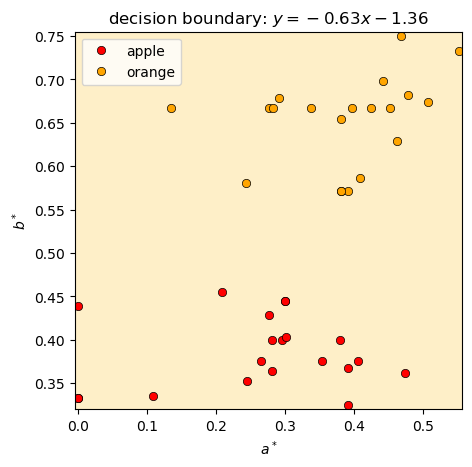

In [29]:
x = np.hstack(([app_a, app_b], [ora_a, ora_b])).T
x = np.column_stack((np.ones(x.shape[0]), x))
y = np.hstack((np.tile([1], 50), np.tile([-1], 50))).T
mcp = MCPerceptron(x.shape, y.shape, epochs=100, lr=1e-1)
mcp.train(x, y)
W = mcp.get_weights()

xmin, xmax = np.min((app_a, ora_a))-5e-3, np.max((app_a, ora_a))+5e-3
ymin, ymax = np.min((app_b, ora_b))-5e-3, np.max((app_b, ora_b))+5e-3
db_x = np.linspace(xmin, xmax, 100)
db_y = np.linspace(ymin, ymax, 100)
xx, yy = np.meshgrid(db_x, db_y)
Z = mcp.predict(np.c_[np.ones_like(xx.ravel()), xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap='YlOrRd', alpha=0.4)
plt.contour(xx, yy, Z, colors='k', linewidths=0.5)
plt.plot(app_a, app_b, 'ro', mec='k', mew=0.5, label='apple')
plt.plot(ora_a, ora_b, 'o', color='orange', mec='k', mew=0.5, label='orange')

decision_boundary = mcp.get_line_params()
bounds[2] = decision_boundary
decision_title = 'decision boundary: $y = %.2fx + %.2f$' if decision_boundary[1] >= 0 \
                 else 'decision boundary: $y = %.2fx - %.2f$'
plt.title(decision_title %(decision_boundary[0], abs(decision_boundary[1])))
plt.legend()
plt.xlabel('$a^*$')
plt.ylabel('$b^*$')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
# plt.savefig('app-ora_decision.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
xmin, xmax = np.min([ban_a, app_a, ora_a]), np.max([ban_a, app_a, ora_a])
ymin, ymax = np.min([ban_b, app_b, ora_b]), np.max([ban_b, app_b, ora_b])
xh = np.linspace(0, 1)

plt.plot(ban_a, ban_b, 'yo', mec='k', mew=0.5, label='banana')
plt.plot(app_a, app_b, 'ro', mec='k', mew=0.5, label='apple')
plt.plot(ora_a, ora_b, 'o', color='orange', mec='k', mew=0.5, label='orange')

for k in bounds:
    plt.plot(xh, k[0]*xh + k[1], 'k')

plt.legend()
plt.xlabel('$a^*$')
plt.ylabel('$b^*$')
plt.xlim(xmin-5e-3, xmax+5e-3)
plt.ylim(ymin-5e-3, ymax+5e-3)
# plt.savefig('all_decision.png', dpi=300, bbox_inches='tight')
plt.show()